# React Agent 实例

In [3]:
! pip install langgraph langsmith langchain-openai


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


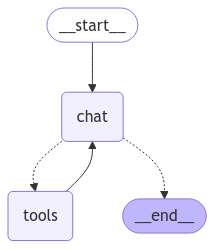

================================ Human Message =================================

帮我修改 hello-egg 的工作负载，镜像为 nginx:v1.0
================================== Ai Message ==================================
Tool Calls:
  get_deployment (call_f5gnFSw8NBmilR88pFQ9rv25)
 Call ID: call_f5gnFSw8NBmilR88pFQ9rv25
  Args:
    deployment_name: hello-egg
get deployment hello-egg
================================= Tool Message =================================
Name: get_deployment


apiVersion: apps/v1
kind: Deployment
metadata:
  creationTimestamp: null
  labels:
    app: hello-egg
  name: hello-egg
spec:
  replicas: 2
  selector:
    matchLabels:
      app: hello-egg
  strategy: { }
  template:
    metadata:
      creationTimestamp: null
      labels:
        app: hello-egg
    spec:
      containers:
        - image: halfcoconut/hello-egg:latest
          name: hello-egg
          resources: { }
status: { } 
    
================================== Ai Message ==================================
Tool Call

In [4]:
import os
from dotenv import load_dotenv
# langgraph chat
from typing import TypedDict, Annotated, Dict, List, Literal
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph
from IPython.display import Image, display

from langgraph.graph import START, END

# 初始化 langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "default"

# https://smith.langchain.com

# 加载 .env 文件
load_dotenv()


@tool
def get_deployment(deployment_name: str):
    """Use this to get deployment YAML"""
    print("get deployment", deployment_name)
    return """
apiVersion: apps/v1
kind: Deployment
metadata:
  creationTimestamp: null
  labels:
    app: hello-egg
  name: hello-egg
spec:
  replicas: 2
  selector:
    matchLabels:
      app: hello-egg
  strategy: { }
  template:
    metadata:
      creationTimestamp: null
      labels:
        app: hello-egg
    spec:
      containers:
        - image: halfcoconut/hello-egg:latest
          name: hello-egg
          resources: { }
status: { } 
    """


@tool
def apply_deployment(patch_json: str):
    """Edit the deployment YAML"""
    print("apply deployment", patch_json)
    # 后续真正调用 k8s API
    return "deployment applied"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


tools = [get_deployment, apply_deployment]
model_with_tools = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"),
                              openai_api_base=os.getenv("OPENAI_API_BASE")).bind_tools(tools)

tools_node = ToolNode(tools)
workflow = StateGraph(MessagesState)
workflow.add_node("chat", call_model)
workflow.add_node("tools", tools_node)

# 创建图
workflow.add_edge("__start__", "chat")
# 循环
workflow.add_conditional_edges(
    "chat", should_continue,
)

workflow.add_edge("tools", "chat")
app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

for chunk in app.stream(
        {"messages": [("human", "帮我修改 hello-egg 的工作负载，镜像为 nginx:v1.0")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()